## Import các thư viện cần thiết

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Khai báo siêu tham số và tải dữ liệu

In [3]:
# Hyperparameters
batch_size = 256
img_size = 28  # original image size is 28x28
channels = 1  # grayscale image
latent_dim = 2
num_epochs = 500  # training epochs

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(
    root="/kaggle/working/data",  # Data storage directory
    train=True,
    transform=transform,
    download=True,
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 78.0MB/s]


Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.56MB/s]


Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]


Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.46MB/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



##  Chia dữ liệu và tạo DataLoader

In [4]:
# split 8/2
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(
    f"Training samples: {len(train_dataset)}, Validation samples: {len(test_dataset)}")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Training samples: 48000, Validation samples: 12000


## Định nghĩa mô hình VAE

### Encoder

In [5]:
class encoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

### Decoder

#### Test output padding

In [6]:
import torch
import torch.nn as nn

# Tạo tensor đầu vào giả (batch_size=1, in_channels=1, H=4, W=4)
x = torch.randn(1, 1, 4, 4)

# ConvTranspose2d với output_padding=0
conv_transpose_0 = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0
)

# ConvTranspose2d với output_padding=1
conv_transpose_1 = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=1
)

# Truyền x qua hai lớp
y0 = conv_transpose_0(x)
y1 = conv_transpose_1(x)

print("Input shape:", x.shape)
print("Output shape với output_padding=0 :", y0.shape)
print("Output shape với output_padding=1 :", y1.shape)

Input shape: torch.Size([1, 1, 4, 4])
Output shape với output_padding=0 : torch.Size([1, 1, 7, 7])
Output shape với output_padding=1 : torch.Size([1, 1, 8, 8])


### decoder

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class dencoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(dencoder, self).__init__()
        self.fc_decoder = nn.Linear(latent_dim, 64*7*7)
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(
            32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x shape: (batch_size, latent_dim)
        x = self.fc_decoder(x)
        # Biến đổi thành (batch_size, 64, 7, 7)
        x = x.view(x.size(0), 64, 7, 7)

        # Qua các tầng transposed convolution
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))

        # Cuối cùng đi qua conv_final, dùng sigmoid vì ảnh grayscale [0, 1]
        x = torch.sigmoid(self.conv_final(x))
        return x


### VAE model

In [8]:
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder(channels, latent_dim)
        self.decoder = dencoder(channels, latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar

## Hàm mất mát của VAE

In [9]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)

    return total_loss, reconstruction_loss, torch.mean(kl_loss)

##  Khởi tạo mô hình và bộ tối ưu

In [10]:
# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Huấn luyện mô hình 

In [11]:
# Training loop with logging removed
model.train()
best_loss = float('inf')  # Khởi tạo giá trị loss tốt nhất (nhỏ nhất) ban đầu

for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(
            recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Tính loss trung bình trên toàn dataset
    avg_loss = train_loss / len(train_loader.dataset)

    # In thông tin kết thúc epoch
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
          f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Lưu best model nếu avg_loss thấp hơn best_loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(
            f"-> Saved best model (epoch {epoch+1}) with avg_loss: {best_loss:.4f}")

print("Training completed.")

Epoch 1/500 Loss per sample: 239.0601 Recon Loss: 48.5072 KL Loss: 46.4170
-> Saved best model (epoch 1) with avg_loss: 239.0601


Epoch 2/500 Loss per sample: 175.5782 Recon Loss: 43.0007 KL Loss: 22.8339
-> Saved best model (epoch 2) with avg_loss: 175.5782


Epoch 3/500 Loss per sample: 162.0613 Recon Loss: 39.9296 KL Loss: 19.2973
-> Saved best model (epoch 3) with avg_loss: 162.0613


Epoch 4/500 Loss per sample: 157.5487 Recon Loss: 38.6972 KL Loss: 17.9864
-> Saved best model (epoch 4) with avg_loss: 157.5487


Epoch 5/500 Loss per sample: 153.9752 Recon Loss: 39.2005 KL Loss: 17.3550
-> Saved best model (epoch 5) with avg_loss: 153.9752


Epoch 6/500 Loss per sample: 150.2801 Recon Loss: 37.2497 KL Loss: 17.4805
-> Saved best model (epoch 6) with avg_loss: 150.2801


Epoch 7/500 Loss per sample: 147.1325 Recon Loss: 38.3229 KL Loss: 16.3448
-> Saved best model (epoch 7) with avg_loss: 147.1325


Epoch 8/500 Loss per sample: 144.4370 Recon Loss: 37.5802 KL Loss: 15.8329
-> Saved best model (epoch 8) with avg_loss: 144.4370


Epoch 9/500 Loss per sample: 142.2105 Recon Loss: 36.6563 KL Loss: 16.2143
-> Saved best model (epoch 9) with avg_loss: 142.2105


Epoch 10/500 Loss per sample: 140.5030 Recon Loss: 35.3720 KL Loss: 16.3454
-> Saved best model (epoch 10) with avg_loss: 140.5030


Epoch 11/500 Loss per sample: 138.8916 Recon Loss: 34.4617 KL Loss: 16.4051
-> Saved best model (epoch 11) with avg_loss: 138.8916


Epoch 12/500 Loss per sample: 137.7762 Recon Loss: 33.8433 KL Loss: 17.0829
-> Saved best model (epoch 12) with avg_loss: 137.7762


Epoch 13/500 Loss per sample: 136.7303 Recon Loss: 34.3210 KL Loss: 16.2368
-> Saved best model (epoch 13) with avg_loss: 136.7303


Epoch 14/500 Loss per sample: 135.6312 Recon Loss: 33.0909 KL Loss: 17.3355
-> Saved best model (epoch 14) with avg_loss: 135.6312


Epoch 15/500 Loss per sample: 135.0378 Recon Loss: 33.8940 KL Loss: 16.6835
-> Saved best model (epoch 15) with avg_loss: 135.0378


Epoch 16/500 Loss per sample: 134.1596 Recon Loss: 34.3892 KL Loss: 15.5565
-> Saved best model (epoch 16) with avg_loss: 134.1596


Epoch 17/500 Loss per sample: 133.5263 Recon Loss: 33.4145 KL Loss: 15.7703
-> Saved best model (epoch 17) with avg_loss: 133.5263


Epoch 18/500 Loss per sample: 132.9739 Recon Loss: 34.0493 KL Loss: 14.7917
-> Saved best model (epoch 18) with avg_loss: 132.9739


Epoch 19/500 Loss per sample: 132.3367 Recon Loss: 32.3004 KL Loss: 15.9706
-> Saved best model (epoch 19) with avg_loss: 132.3367


Epoch 20/500 Loss per sample: 131.7735 Recon Loss: 33.2948 KL Loss: 15.8341
-> Saved best model (epoch 20) with avg_loss: 131.7735


Epoch 21/500 Loss per sample: 131.2290 Recon Loss: 34.4491 KL Loss: 15.1997
-> Saved best model (epoch 21) with avg_loss: 131.2290


Epoch 22/500 Loss per sample: 130.6430 Recon Loss: 32.6779 KL Loss: 15.0657
-> Saved best model (epoch 22) with avg_loss: 130.6430


Epoch 23/500 Loss per sample: 130.2774 Recon Loss: 35.1119 KL Loss: 15.1320
-> Saved best model (epoch 23) with avg_loss: 130.2774


Epoch 24/500 Loss per sample: 129.9148 Recon Loss: 34.6920 KL Loss: 15.0748
-> Saved best model (epoch 24) with avg_loss: 129.9148


Epoch 25/500 Loss per sample: 129.4604 Recon Loss: 34.7422 KL Loss: 14.7002
-> Saved best model (epoch 25) with avg_loss: 129.4604


Epoch 26/500 Loss per sample: 129.1121 Recon Loss: 32.5268 KL Loss: 14.8536
-> Saved best model (epoch 26) with avg_loss: 129.1121


Epoch 27/500 Loss per sample: 128.7285 Recon Loss: 32.2002 KL Loss: 15.0181
-> Saved best model (epoch 27) with avg_loss: 128.7285


Epoch 28/500 Loss per sample: 128.4008 Recon Loss: 34.6380 KL Loss: 15.4207
-> Saved best model (epoch 28) with avg_loss: 128.4008


Epoch 29/500 Loss per sample: 128.0185 Recon Loss: 32.5953 KL Loss: 15.0263
-> Saved best model (epoch 29) with avg_loss: 128.0185


Epoch 30/500 Loss per sample: 127.7572 Recon Loss: 34.1084 KL Loss: 14.9410
-> Saved best model (epoch 30) with avg_loss: 127.7572


Epoch 31/500 Loss per sample: 127.4861 Recon Loss: 31.8726 KL Loss: 15.7409
-> Saved best model (epoch 31) with avg_loss: 127.4861


Epoch 32/500 Loss per sample: 127.2261 Recon Loss: 32.5176 KL Loss: 15.2945
-> Saved best model (epoch 32) with avg_loss: 127.2261


Epoch 33/500 Loss per sample: 126.9844 Recon Loss: 32.8706 KL Loss: 15.5911
-> Saved best model (epoch 33) with avg_loss: 126.9844


Epoch 34/500 Loss per sample: 126.7509 Recon Loss: 33.3302 KL Loss: 15.2271
-> Saved best model (epoch 34) with avg_loss: 126.7509


Epoch 35/500 Loss per sample: 126.4792 Recon Loss: 33.7412 KL Loss: 15.1789
-> Saved best model (epoch 35) with avg_loss: 126.4792


Epoch 36/500 Loss per sample: 126.2854 Recon Loss: 32.8303 KL Loss: 14.9544
-> Saved best model (epoch 36) with avg_loss: 126.2854


Epoch 37/500 Loss per sample: 126.0964 Recon Loss: 32.1212 KL Loss: 14.8520
-> Saved best model (epoch 37) with avg_loss: 126.0964


Epoch 38/500 Loss per sample: 125.8279 Recon Loss: 32.4002 KL Loss: 15.0368
-> Saved best model (epoch 38) with avg_loss: 125.8279


Epoch 39/500 Loss per sample: 125.7272 Recon Loss: 32.3082 KL Loss: 15.8192
-> Saved best model (epoch 39) with avg_loss: 125.7272


Epoch 40/500 Loss per sample: 125.5759 Recon Loss: 33.7763 KL Loss: 14.6924
-> Saved best model (epoch 40) with avg_loss: 125.5759


Epoch 41/500 Loss per sample: 125.3681 Recon Loss: 31.6333 KL Loss: 14.7048
-> Saved best model (epoch 41) with avg_loss: 125.3681


Epoch 42/500 Loss per sample: 125.1221 Recon Loss: 34.4219 KL Loss: 14.8679
-> Saved best model (epoch 42) with avg_loss: 125.1221


Epoch 43/500 Loss per sample: 124.9717 Recon Loss: 31.9805 KL Loss: 14.6471
-> Saved best model (epoch 43) with avg_loss: 124.9717


Epoch 44/500 Loss per sample: 124.8265 Recon Loss: 31.9790 KL Loss: 15.0956
-> Saved best model (epoch 44) with avg_loss: 124.8265


Epoch 45/500 Loss per sample: 124.7959 Recon Loss: 31.2444 KL Loss: 14.6862
-> Saved best model (epoch 45) with avg_loss: 124.7959


Epoch 46/500 Loss per sample: 124.4522 Recon Loss: 31.3968 KL Loss: 15.7012
-> Saved best model (epoch 46) with avg_loss: 124.4522


Epoch 47/500 Loss per sample: 124.3735 Recon Loss: 32.1642 KL Loss: 15.0257
-> Saved best model (epoch 47) with avg_loss: 124.3735


Epoch 48/500 Loss per sample: 124.3968 Recon Loss: 30.9161 KL Loss: 15.5368


Epoch 49/500 Loss per sample: 123.9730 Recon Loss: 29.6326 KL Loss: 16.1459
-> Saved best model (epoch 49) with avg_loss: 123.9730


Epoch 50/500 Loss per sample: 124.0515 Recon Loss: 32.2037 KL Loss: 13.9167


Epoch 51/500 Loss per sample: 123.9220 Recon Loss: 34.2173 KL Loss: 14.9202
-> Saved best model (epoch 51) with avg_loss: 123.9220


Epoch 52/500 Loss per sample: 123.6062 Recon Loss: 30.7006 KL Loss: 16.0040
-> Saved best model (epoch 52) with avg_loss: 123.6062


Epoch 53/500 Loss per sample: 123.6159 Recon Loss: 31.1814 KL Loss: 15.4727


Epoch 54/500 Loss per sample: 123.6744 Recon Loss: 35.9896 KL Loss: 14.0684


Epoch 55/500 Loss per sample: 123.3203 Recon Loss: 31.0086 KL Loss: 14.9061
-> Saved best model (epoch 55) with avg_loss: 123.3203


Epoch 56/500 Loss per sample: 123.2267 Recon Loss: 31.6222 KL Loss: 15.3726
-> Saved best model (epoch 56) with avg_loss: 123.2267


Epoch 57/500 Loss per sample: 123.2123 Recon Loss: 32.2818 KL Loss: 14.8593
-> Saved best model (epoch 57) with avg_loss: 123.2123


Epoch 58/500 Loss per sample: 122.9729 Recon Loss: 33.0308 KL Loss: 14.5589
-> Saved best model (epoch 58) with avg_loss: 122.9729


Epoch 59/500 Loss per sample: 122.9575 Recon Loss: 31.4917 KL Loss: 15.4887
-> Saved best model (epoch 59) with avg_loss: 122.9575


Epoch 60/500 Loss per sample: 122.7053 Recon Loss: 31.1017 KL Loss: 15.1628
-> Saved best model (epoch 60) with avg_loss: 122.7053


Epoch 61/500 Loss per sample: 122.6342 Recon Loss: 30.2752 KL Loss: 15.1810
-> Saved best model (epoch 61) with avg_loss: 122.6342


Epoch 62/500 Loss per sample: 122.6063 Recon Loss: 32.1231 KL Loss: 14.8843
-> Saved best model (epoch 62) with avg_loss: 122.6063


Epoch 63/500 Loss per sample: 122.5140 Recon Loss: 31.6830 KL Loss: 15.5940
-> Saved best model (epoch 63) with avg_loss: 122.5140


Epoch 64/500 Loss per sample: 122.3534 Recon Loss: 30.3905 KL Loss: 14.9898
-> Saved best model (epoch 64) with avg_loss: 122.3534


Epoch 65/500 Loss per sample: 122.2805 Recon Loss: 30.4381 KL Loss: 14.7568
-> Saved best model (epoch 65) with avg_loss: 122.2805


Epoch 66/500 Loss per sample: 122.2209 Recon Loss: 30.6266 KL Loss: 15.6422
-> Saved best model (epoch 66) with avg_loss: 122.2209


Epoch 67/500 Loss per sample: 122.0226 Recon Loss: 29.7281 KL Loss: 14.8740
-> Saved best model (epoch 67) with avg_loss: 122.0226


Epoch 68/500 Loss per sample: 122.1136 Recon Loss: 32.0810 KL Loss: 15.1063


Epoch 69/500 Loss per sample: 121.9430 Recon Loss: 32.2379 KL Loss: 15.8232
-> Saved best model (epoch 69) with avg_loss: 121.9430


Epoch 70/500 Loss per sample: 121.7527 Recon Loss: 28.2132 KL Loss: 16.0394
-> Saved best model (epoch 70) with avg_loss: 121.7527


Epoch 71/500 Loss per sample: 121.7319 Recon Loss: 30.0900 KL Loss: 15.9971
-> Saved best model (epoch 71) with avg_loss: 121.7319


Epoch 72/500 Loss per sample: 121.6643 Recon Loss: 33.2788 KL Loss: 15.0295
-> Saved best model (epoch 72) with avg_loss: 121.6643


Epoch 73/500 Loss per sample: 121.6981 Recon Loss: 32.9640 KL Loss: 15.4514


Epoch 74/500 Loss per sample: 121.5766 Recon Loss: 33.3085 KL Loss: 14.7858
-> Saved best model (epoch 74) with avg_loss: 121.5766


Epoch 75/500 Loss per sample: 121.4020 Recon Loss: 31.1528 KL Loss: 14.7090
-> Saved best model (epoch 75) with avg_loss: 121.4020


Epoch 76/500 Loss per sample: 121.2543 Recon Loss: 32.3661 KL Loss: 14.9285
-> Saved best model (epoch 76) with avg_loss: 121.2543


Epoch 77/500 Loss per sample: 121.3357 Recon Loss: 32.3643 KL Loss: 14.0593


Epoch 78/500 Loss per sample: 121.2318 Recon Loss: 30.5599 KL Loss: 15.0376
-> Saved best model (epoch 78) with avg_loss: 121.2318


Epoch 79/500 Loss per sample: 121.1386 Recon Loss: 31.8356 KL Loss: 15.3240
-> Saved best model (epoch 79) with avg_loss: 121.1386


Epoch 80/500 Loss per sample: 120.9819 Recon Loss: 31.0248 KL Loss: 15.2627
-> Saved best model (epoch 80) with avg_loss: 120.9819


Epoch 81/500 Loss per sample: 120.8826 Recon Loss: 30.4635 KL Loss: 14.9718
-> Saved best model (epoch 81) with avg_loss: 120.8826


Epoch 82/500 Loss per sample: 121.0452 Recon Loss: 32.4155 KL Loss: 15.5526


Epoch 83/500 Loss per sample: 120.9003 Recon Loss: 32.4563 KL Loss: 14.2194


Epoch 84/500 Loss per sample: 120.8399 Recon Loss: 34.2732 KL Loss: 14.1539
-> Saved best model (epoch 84) with avg_loss: 120.8399


Epoch 85/500 Loss per sample: 120.7401 Recon Loss: 30.8564 KL Loss: 15.6157
-> Saved best model (epoch 85) with avg_loss: 120.7401


Epoch 86/500 Loss per sample: 120.5787 Recon Loss: 32.1509 KL Loss: 15.5855
-> Saved best model (epoch 86) with avg_loss: 120.5787


Epoch 87/500 Loss per sample: 120.6402 Recon Loss: 31.2172 KL Loss: 15.3876


Epoch 88/500 Loss per sample: 120.4987 Recon Loss: 30.0801 KL Loss: 15.7371
-> Saved best model (epoch 88) with avg_loss: 120.4987


Epoch 89/500 Loss per sample: 120.4652 Recon Loss: 31.0255 KL Loss: 14.2168
-> Saved best model (epoch 89) with avg_loss: 120.4652


Epoch 90/500 Loss per sample: 120.4388 Recon Loss: 30.9401 KL Loss: 14.9854
-> Saved best model (epoch 90) with avg_loss: 120.4388


Epoch 91/500 Loss per sample: 120.3418 Recon Loss: 29.4385 KL Loss: 16.1432
-> Saved best model (epoch 91) with avg_loss: 120.3418


Epoch 92/500 Loss per sample: 120.2523 Recon Loss: 30.8615 KL Loss: 14.9745
-> Saved best model (epoch 92) with avg_loss: 120.2523


Epoch 93/500 Loss per sample: 120.3165 Recon Loss: 32.0627 KL Loss: 15.4450


Epoch 94/500 Loss per sample: 120.1955 Recon Loss: 30.1388 KL Loss: 14.7216
-> Saved best model (epoch 94) with avg_loss: 120.1955


Epoch 95/500 Loss per sample: 120.1552 Recon Loss: 33.9233 KL Loss: 14.9128
-> Saved best model (epoch 95) with avg_loss: 120.1552


Epoch 96/500 Loss per sample: 120.0645 Recon Loss: 30.8335 KL Loss: 14.6337
-> Saved best model (epoch 96) with avg_loss: 120.0645


Epoch 97/500 Loss per sample: 120.0477 Recon Loss: 31.3732 KL Loss: 15.5143
-> Saved best model (epoch 97) with avg_loss: 120.0477


Epoch 98/500 Loss per sample: 119.9435 Recon Loss: 30.1784 KL Loss: 15.8556
-> Saved best model (epoch 98) with avg_loss: 119.9435


Epoch 99/500 Loss per sample: 119.9118 Recon Loss: 32.4160 KL Loss: 14.7317
-> Saved best model (epoch 99) with avg_loss: 119.9118


Epoch 100/500 Loss per sample: 119.8321 Recon Loss: 29.2535 KL Loss: 15.7746
-> Saved best model (epoch 100) with avg_loss: 119.8321


Epoch 101/500 Loss per sample: 119.7742 Recon Loss: 31.5303 KL Loss: 14.1044
-> Saved best model (epoch 101) with avg_loss: 119.7742


Epoch 102/500 Loss per sample: 119.8136 Recon Loss: 29.5926 KL Loss: 16.1138


Epoch 103/500 Loss per sample: 119.7095 Recon Loss: 31.4557 KL Loss: 15.3202
-> Saved best model (epoch 103) with avg_loss: 119.7095


Epoch 104/500 Loss per sample: 119.6536 Recon Loss: 30.5855 KL Loss: 15.9183
-> Saved best model (epoch 104) with avg_loss: 119.6536


Epoch 105/500 Loss per sample: 119.6112 Recon Loss: 33.3533 KL Loss: 15.1515
-> Saved best model (epoch 105) with avg_loss: 119.6112


Epoch 106/500 Loss per sample: 119.4479 Recon Loss: 29.7132 KL Loss: 15.2564
-> Saved best model (epoch 106) with avg_loss: 119.4479


Epoch 107/500 Loss per sample: 119.5945 Recon Loss: 29.8035 KL Loss: 15.7783


Epoch 108/500 Loss per sample: 119.5207 Recon Loss: 31.8623 KL Loss: 14.8206


Epoch 109/500 Loss per sample: 119.3735 Recon Loss: 31.2965 KL Loss: 14.7759
-> Saved best model (epoch 109) with avg_loss: 119.3735


Epoch 110/500 Loss per sample: 119.2557 Recon Loss: 30.6633 KL Loss: 15.6401
-> Saved best model (epoch 110) with avg_loss: 119.2557


Epoch 111/500 Loss per sample: 119.3034 Recon Loss: 28.3103 KL Loss: 15.5179


Epoch 112/500 Loss per sample: 119.2163 Recon Loss: 30.4653 KL Loss: 16.2657
-> Saved best model (epoch 112) with avg_loss: 119.2163


Epoch 113/500 Loss per sample: 119.2488 Recon Loss: 30.6321 KL Loss: 15.6788


Epoch 114/500 Loss per sample: 119.1603 Recon Loss: 29.1334 KL Loss: 15.2447
-> Saved best model (epoch 114) with avg_loss: 119.1603


Epoch 115/500 Loss per sample: 119.2339 Recon Loss: 32.4465 KL Loss: 15.0518


Epoch 116/500 Loss per sample: 119.1014 Recon Loss: 29.6778 KL Loss: 17.1445
-> Saved best model (epoch 116) with avg_loss: 119.1014


Epoch 117/500 Loss per sample: 119.0822 Recon Loss: 27.6968 KL Loss: 15.7424
-> Saved best model (epoch 117) with avg_loss: 119.0822


Epoch 118/500 Loss per sample: 119.0630 Recon Loss: 31.1629 KL Loss: 15.8437
-> Saved best model (epoch 118) with avg_loss: 119.0630


Epoch 119/500 Loss per sample: 119.0918 Recon Loss: 29.5880 KL Loss: 16.0782


Epoch 120/500 Loss per sample: 118.9611 Recon Loss: 28.8455 KL Loss: 15.3644
-> Saved best model (epoch 120) with avg_loss: 118.9611


Epoch 121/500 Loss per sample: 118.9592 Recon Loss: 29.8326 KL Loss: 16.0988
-> Saved best model (epoch 121) with avg_loss: 118.9592


Epoch 122/500 Loss per sample: 118.9242 Recon Loss: 31.8412 KL Loss: 15.9000
-> Saved best model (epoch 122) with avg_loss: 118.9242


Epoch 123/500 Loss per sample: 118.9544 Recon Loss: 31.2051 KL Loss: 14.8849


Epoch 124/500 Loss per sample: 118.9546 Recon Loss: 31.6497 KL Loss: 15.2530


Epoch 125/500 Loss per sample: 118.6642 Recon Loss: 28.8182 KL Loss: 15.6429
-> Saved best model (epoch 125) with avg_loss: 118.6642


Epoch 126/500 Loss per sample: 118.7245 Recon Loss: 30.7033 KL Loss: 14.8528


Epoch 127/500 Loss per sample: 118.7571 Recon Loss: 29.5365 KL Loss: 15.1777


Epoch 128/500 Loss per sample: 118.6269 Recon Loss: 26.8438 KL Loss: 16.2701
-> Saved best model (epoch 128) with avg_loss: 118.6269


Epoch 129/500 Loss per sample: 118.6769 Recon Loss: 29.3163 KL Loss: 15.0194


Epoch 130/500 Loss per sample: 118.5452 Recon Loss: 31.9475 KL Loss: 14.5048
-> Saved best model (epoch 130) with avg_loss: 118.5452


Epoch 131/500 Loss per sample: 118.3982 Recon Loss: 28.2005 KL Loss: 15.5882
-> Saved best model (epoch 131) with avg_loss: 118.3982


Epoch 132/500 Loss per sample: 118.5291 Recon Loss: 30.7283 KL Loss: 15.6463


Epoch 133/500 Loss per sample: 118.5970 Recon Loss: 30.0176 KL Loss: 15.5804


Epoch 134/500 Loss per sample: 118.4648 Recon Loss: 30.7059 KL Loss: 15.4358


Epoch 135/500 Loss per sample: 118.3667 Recon Loss: 30.6069 KL Loss: 15.4127
-> Saved best model (epoch 135) with avg_loss: 118.3667


Epoch 136/500 Loss per sample: 118.3694 Recon Loss: 31.6812 KL Loss: 15.2090


Epoch 137/500 Loss per sample: 118.3748 Recon Loss: 31.0070 KL Loss: 15.1190


Epoch 138/500 Loss per sample: 118.3473 Recon Loss: 31.5722 KL Loss: 15.0687
-> Saved best model (epoch 138) with avg_loss: 118.3473


Epoch 139/500 Loss per sample: 118.2873 Recon Loss: 31.3805 KL Loss: 14.9319
-> Saved best model (epoch 139) with avg_loss: 118.2873


Epoch 140/500 Loss per sample: 118.3178 Recon Loss: 30.5093 KL Loss: 16.1641


Epoch 141/500 Loss per sample: 118.3515 Recon Loss: 28.3038 KL Loss: 16.5173


Epoch 142/500 Loss per sample: 118.1826 Recon Loss: 29.1642 KL Loss: 15.9961
-> Saved best model (epoch 142) with avg_loss: 118.1826


Epoch 143/500 Loss per sample: 118.2298 Recon Loss: 33.3566 KL Loss: 15.1806


Epoch 144/500 Loss per sample: 118.1335 Recon Loss: 27.7021 KL Loss: 15.8072
-> Saved best model (epoch 144) with avg_loss: 118.1335


Epoch 145/500 Loss per sample: 118.1103 Recon Loss: 30.6128 KL Loss: 15.6203
-> Saved best model (epoch 145) with avg_loss: 118.1103


Epoch 146/500 Loss per sample: 118.1168 Recon Loss: 29.8077 KL Loss: 15.8924


Epoch 147/500 Loss per sample: 118.1014 Recon Loss: 28.8538 KL Loss: 15.7401
-> Saved best model (epoch 147) with avg_loss: 118.1014


Epoch 148/500 Loss per sample: 118.0884 Recon Loss: 29.4050 KL Loss: 15.8863
-> Saved best model (epoch 148) with avg_loss: 118.0884


Epoch 149/500 Loss per sample: 118.0553 Recon Loss: 33.2362 KL Loss: 15.0641
-> Saved best model (epoch 149) with avg_loss: 118.0553


Epoch 150/500 Loss per sample: 117.8865 Recon Loss: 29.6089 KL Loss: 15.7460
-> Saved best model (epoch 150) with avg_loss: 117.8865


Epoch 151/500 Loss per sample: 117.9138 Recon Loss: 30.8032 KL Loss: 15.7628


Epoch 152/500 Loss per sample: 117.9604 Recon Loss: 31.2443 KL Loss: 14.9366


Epoch 153/500 Loss per sample: 117.8652 Recon Loss: 28.9399 KL Loss: 15.8866
-> Saved best model (epoch 153) with avg_loss: 117.8652


Epoch 154/500 Loss per sample: 117.8180 Recon Loss: 28.6795 KL Loss: 17.4929
-> Saved best model (epoch 154) with avg_loss: 117.8180


Epoch 155/500 Loss per sample: 117.8528 Recon Loss: 29.8063 KL Loss: 16.0509


Epoch 156/500 Loss per sample: 117.7189 Recon Loss: 28.5448 KL Loss: 15.8968
-> Saved best model (epoch 156) with avg_loss: 117.7189


Epoch 157/500 Loss per sample: 117.7939 Recon Loss: 30.6790 KL Loss: 14.4708


Epoch 158/500 Loss per sample: 117.8105 Recon Loss: 31.4308 KL Loss: 14.7190


Epoch 159/500 Loss per sample: 117.7446 Recon Loss: 30.8267 KL Loss: 15.9176


Epoch 160/500 Loss per sample: 117.8816 Recon Loss: 29.2103 KL Loss: 15.7695


Epoch 161/500 Loss per sample: 117.6767 Recon Loss: 28.2989 KL Loss: 15.8089
-> Saved best model (epoch 161) with avg_loss: 117.6767


Epoch 162/500 Loss per sample: 117.5225 Recon Loss: 29.0417 KL Loss: 16.1696
-> Saved best model (epoch 162) with avg_loss: 117.5225


Epoch 163/500 Loss per sample: 117.5999 Recon Loss: 28.9981 KL Loss: 15.9437


Epoch 164/500 Loss per sample: 117.5711 Recon Loss: 29.0677 KL Loss: 15.2880


Epoch 165/500 Loss per sample: 117.6846 Recon Loss: 29.9585 KL Loss: 15.7813


Epoch 166/500 Loss per sample: 117.5073 Recon Loss: 32.1373 KL Loss: 15.0080
-> Saved best model (epoch 166) with avg_loss: 117.5073


Epoch 167/500 Loss per sample: 117.6164 Recon Loss: 30.7454 KL Loss: 14.8748


Epoch 168/500 Loss per sample: 117.4500 Recon Loss: 30.5999 KL Loss: 15.6921
-> Saved best model (epoch 168) with avg_loss: 117.4500


Epoch 169/500 Loss per sample: 117.5012 Recon Loss: 30.8897 KL Loss: 15.3630


Epoch 170/500 Loss per sample: 117.4717 Recon Loss: 30.4811 KL Loss: 15.8133


Epoch 171/500 Loss per sample: 117.4558 Recon Loss: 31.4863 KL Loss: 16.2861


Epoch 172/500 Loss per sample: 117.5529 Recon Loss: 29.4434 KL Loss: 17.1198


Epoch 173/500 Loss per sample: 117.4054 Recon Loss: 32.2315 KL Loss: 14.4087
-> Saved best model (epoch 173) with avg_loss: 117.4054


Epoch 174/500 Loss per sample: 117.5090 Recon Loss: 29.8170 KL Loss: 15.0464


Epoch 175/500 Loss per sample: 117.3137 Recon Loss: 28.2159 KL Loss: 17.5920
-> Saved best model (epoch 175) with avg_loss: 117.3137


Epoch 176/500 Loss per sample: 117.3663 Recon Loss: 30.9993 KL Loss: 15.4804


Epoch 177/500 Loss per sample: 117.2408 Recon Loss: 28.9854 KL Loss: 15.7135
-> Saved best model (epoch 177) with avg_loss: 117.2408


Epoch 178/500 Loss per sample: 117.2001 Recon Loss: 30.0431 KL Loss: 16.4262
-> Saved best model (epoch 178) with avg_loss: 117.2001


Epoch 179/500 Loss per sample: 117.2624 Recon Loss: 27.5787 KL Loss: 17.0686


Epoch 180/500 Loss per sample: 117.2979 Recon Loss: 30.6202 KL Loss: 14.8479


Epoch 181/500 Loss per sample: 117.1392 Recon Loss: 30.2963 KL Loss: 15.7558
-> Saved best model (epoch 181) with avg_loss: 117.1392


Epoch 182/500 Loss per sample: 117.2371 Recon Loss: 30.0858 KL Loss: 15.5352


Epoch 183/500 Loss per sample: 117.0882 Recon Loss: 30.0651 KL Loss: 16.1109
-> Saved best model (epoch 183) with avg_loss: 117.0882


Epoch 184/500 Loss per sample: 117.0055 Recon Loss: 31.2584 KL Loss: 16.7628
-> Saved best model (epoch 184) with avg_loss: 117.0055


Epoch 185/500 Loss per sample: 117.0463 Recon Loss: 28.1396 KL Loss: 17.2320


Epoch 186/500 Loss per sample: 117.0728 Recon Loss: 29.5356 KL Loss: 16.4805


Epoch 187/500 Loss per sample: 117.1683 Recon Loss: 31.5464 KL Loss: 15.0144


Epoch 188/500 Loss per sample: 117.0762 Recon Loss: 28.7213 KL Loss: 16.0491


Epoch 189/500 Loss per sample: 117.0082 Recon Loss: 31.2028 KL Loss: 15.5090


Epoch 190/500 Loss per sample: 117.0379 Recon Loss: 28.0133 KL Loss: 15.9079


Epoch 191/500 Loss per sample: 117.0610 Recon Loss: 31.4385 KL Loss: 15.0904


Epoch 192/500 Loss per sample: 116.9843 Recon Loss: 31.3857 KL Loss: 14.8739
-> Saved best model (epoch 192) with avg_loss: 116.9843


Epoch 193/500 Loss per sample: 116.9801 Recon Loss: 31.7787 KL Loss: 16.0165
-> Saved best model (epoch 193) with avg_loss: 116.9801


Epoch 194/500 Loss per sample: 116.9889 Recon Loss: 28.8903 KL Loss: 16.4145


Epoch 195/500 Loss per sample: 116.9699 Recon Loss: 27.7426 KL Loss: 16.5076
-> Saved best model (epoch 195) with avg_loss: 116.9699


Epoch 196/500 Loss per sample: 116.8263 Recon Loss: 31.4849 KL Loss: 14.6173
-> Saved best model (epoch 196) with avg_loss: 116.8263


Epoch 197/500 Loss per sample: 116.8696 Recon Loss: 30.3191 KL Loss: 16.2586


Epoch 198/500 Loss per sample: 116.7716 Recon Loss: 30.0902 KL Loss: 16.0080
-> Saved best model (epoch 198) with avg_loss: 116.7716


Epoch 199/500 Loss per sample: 116.7383 Recon Loss: 30.7589 KL Loss: 16.1115
-> Saved best model (epoch 199) with avg_loss: 116.7383


Epoch 200/500 Loss per sample: 116.7945 Recon Loss: 28.0715 KL Loss: 16.7278


Epoch 201/500 Loss per sample: 116.8109 Recon Loss: 31.1614 KL Loss: 13.7795


Epoch 202/500 Loss per sample: 116.8059 Recon Loss: 31.3945 KL Loss: 15.4448


Epoch 203/500 Loss per sample: 116.7181 Recon Loss: 29.6440 KL Loss: 14.9092
-> Saved best model (epoch 203) with avg_loss: 116.7181


Epoch 204/500 Loss per sample: 116.7073 Recon Loss: 29.9713 KL Loss: 16.9000
-> Saved best model (epoch 204) with avg_loss: 116.7073


Epoch 205/500 Loss per sample: 116.6821 Recon Loss: 29.1714 KL Loss: 16.5269
-> Saved best model (epoch 205) with avg_loss: 116.6821


Epoch 206/500 Loss per sample: 116.7178 Recon Loss: 29.8598 KL Loss: 16.4999


Epoch 207/500 Loss per sample: 116.7815 Recon Loss: 29.3243 KL Loss: 16.0315


Epoch 208/500 Loss per sample: 116.6819 Recon Loss: 30.3322 KL Loss: 15.2351
-> Saved best model (epoch 208) with avg_loss: 116.6819


Epoch 209/500 Loss per sample: 116.5897 Recon Loss: 28.8647 KL Loss: 16.1151
-> Saved best model (epoch 209) with avg_loss: 116.5897


Epoch 210/500 Loss per sample: 116.6482 Recon Loss: 31.1145 KL Loss: 16.1977


Epoch 211/500 Loss per sample: 116.6731 Recon Loss: 30.6711 KL Loss: 15.0968


Epoch 212/500 Loss per sample: 116.5782 Recon Loss: 30.7162 KL Loss: 15.7421
-> Saved best model (epoch 212) with avg_loss: 116.5782


Epoch 213/500 Loss per sample: 116.5793 Recon Loss: 29.9357 KL Loss: 15.9811


Epoch 214/500 Loss per sample: 116.6212 Recon Loss: 29.0184 KL Loss: 15.2195


Epoch 215/500 Loss per sample: 116.5306 Recon Loss: 30.0771 KL Loss: 15.6947
-> Saved best model (epoch 215) with avg_loss: 116.5306


Epoch 216/500 Loss per sample: 116.5425 Recon Loss: 29.1322 KL Loss: 15.7795


Epoch 217/500 Loss per sample: 116.5715 Recon Loss: 29.9886 KL Loss: 15.3124


Epoch 218/500 Loss per sample: 116.4098 Recon Loss: 29.2169 KL Loss: 16.3727
-> Saved best model (epoch 218) with avg_loss: 116.4098


Epoch 219/500 Loss per sample: 116.5348 Recon Loss: 31.8335 KL Loss: 16.5823


Epoch 220/500 Loss per sample: 116.4437 Recon Loss: 27.7889 KL Loss: 16.1869


Epoch 221/500 Loss per sample: 116.4290 Recon Loss: 30.7572 KL Loss: 15.0319


Epoch 222/500 Loss per sample: 116.3495 Recon Loss: 28.6512 KL Loss: 16.3292
-> Saved best model (epoch 222) with avg_loss: 116.3495


Epoch 223/500 Loss per sample: 116.4062 Recon Loss: 28.4308 KL Loss: 16.7044


Epoch 224/500 Loss per sample: 116.5093 Recon Loss: 31.2577 KL Loss: 15.8261


Epoch 225/500 Loss per sample: 116.3554 Recon Loss: 30.1537 KL Loss: 15.8747


Epoch 226/500 Loss per sample: 116.4727 Recon Loss: 28.8823 KL Loss: 17.1534


Epoch 227/500 Loss per sample: 116.5186 Recon Loss: 30.5733 KL Loss: 15.9096


Epoch 228/500 Loss per sample: 116.3375 Recon Loss: 29.7708 KL Loss: 14.7301
-> Saved best model (epoch 228) with avg_loss: 116.3375


Epoch 229/500 Loss per sample: 116.2456 Recon Loss: 25.6557 KL Loss: 16.5539
-> Saved best model (epoch 229) with avg_loss: 116.2456


Epoch 230/500 Loss per sample: 116.3281 Recon Loss: 31.4593 KL Loss: 16.0725


Epoch 231/500 Loss per sample: 116.3334 Recon Loss: 29.9583 KL Loss: 15.4096


Epoch 232/500 Loss per sample: 116.1257 Recon Loss: 30.0488 KL Loss: 14.7816
-> Saved best model (epoch 232) with avg_loss: 116.1257


Epoch 233/500 Loss per sample: 116.2155 Recon Loss: 31.0998 KL Loss: 15.5213


Epoch 234/500 Loss per sample: 116.3421 Recon Loss: 31.0466 KL Loss: 14.5302


Epoch 235/500 Loss per sample: 116.1492 Recon Loss: 28.2242 KL Loss: 16.4856


Epoch 236/500 Loss per sample: 116.2665 Recon Loss: 30.8776 KL Loss: 16.6456


Epoch 237/500 Loss per sample: 116.3173 Recon Loss: 31.7575 KL Loss: 16.0747


Epoch 238/500 Loss per sample: 116.4215 Recon Loss: 31.2767 KL Loss: 15.4716


Epoch 239/500 Loss per sample: 116.1395 Recon Loss: 30.6867 KL Loss: 15.5806


Epoch 240/500 Loss per sample: 116.1676 Recon Loss: 30.0508 KL Loss: 15.6791


Epoch 241/500 Loss per sample: 116.2567 Recon Loss: 30.9378 KL Loss: 14.8390


Epoch 242/500 Loss per sample: 116.1367 Recon Loss: 28.6812 KL Loss: 17.6867


Epoch 243/500 Loss per sample: 116.2275 Recon Loss: 29.4865 KL Loss: 16.2057


Epoch 244/500 Loss per sample: 115.9833 Recon Loss: 31.0552 KL Loss: 16.0837
-> Saved best model (epoch 244) with avg_loss: 115.9833


Epoch 245/500 Loss per sample: 116.1845 Recon Loss: 30.6447 KL Loss: 17.0394


Epoch 246/500 Loss per sample: 116.0182 Recon Loss: 30.0542 KL Loss: 15.4113


Epoch 247/500 Loss per sample: 116.2011 Recon Loss: 29.5934 KL Loss: 15.1682


Epoch 248/500 Loss per sample: 116.1308 Recon Loss: 30.7861 KL Loss: 15.8266


Epoch 249/500 Loss per sample: 116.0328 Recon Loss: 29.7443 KL Loss: 16.0710


Epoch 250/500 Loss per sample: 115.9023 Recon Loss: 29.6351 KL Loss: 15.3920
-> Saved best model (epoch 250) with avg_loss: 115.9023


Epoch 251/500 Loss per sample: 116.0254 Recon Loss: 28.3211 KL Loss: 16.2052


Epoch 252/500 Loss per sample: 116.0323 Recon Loss: 32.0889 KL Loss: 15.3226


Epoch 253/500 Loss per sample: 116.0741 Recon Loss: 29.7657 KL Loss: 16.4677


Epoch 254/500 Loss per sample: 115.8894 Recon Loss: 31.6880 KL Loss: 15.2959
-> Saved best model (epoch 254) with avg_loss: 115.8894


Epoch 255/500 Loss per sample: 116.0121 Recon Loss: 27.6219 KL Loss: 16.8439


Epoch 256/500 Loss per sample: 115.9466 Recon Loss: 29.4872 KL Loss: 17.7061


Epoch 257/500 Loss per sample: 115.8409 Recon Loss: 27.8147 KL Loss: 19.1497
-> Saved best model (epoch 257) with avg_loss: 115.8409


Epoch 258/500 Loss per sample: 115.8675 Recon Loss: 28.6368 KL Loss: 15.9614


Epoch 259/500 Loss per sample: 115.9279 Recon Loss: 31.3416 KL Loss: 16.2739


Epoch 260/500 Loss per sample: 115.9911 Recon Loss: 30.7267 KL Loss: 16.4606


Epoch 261/500 Loss per sample: 115.9248 Recon Loss: 27.5069 KL Loss: 16.0999


Epoch 262/500 Loss per sample: 115.8860 Recon Loss: 28.5373 KL Loss: 16.3617


Epoch 263/500 Loss per sample: 115.9499 Recon Loss: 29.4712 KL Loss: 16.0479


Epoch 264/500 Loss per sample: 115.9228 Recon Loss: 31.1530 KL Loss: 15.8556


Epoch 265/500 Loss per sample: 115.9233 Recon Loss: 28.2764 KL Loss: 14.9090


Epoch 266/500 Loss per sample: 115.6834 Recon Loss: 28.4843 KL Loss: 15.6067
-> Saved best model (epoch 266) with avg_loss: 115.6834


Epoch 267/500 Loss per sample: 115.8065 Recon Loss: 29.9476 KL Loss: 15.9121


Epoch 268/500 Loss per sample: 115.8592 Recon Loss: 28.1015 KL Loss: 16.5019


Epoch 269/500 Loss per sample: 115.9081 Recon Loss: 30.9057 KL Loss: 15.4013


Epoch 270/500 Loss per sample: 115.8903 Recon Loss: 28.2523 KL Loss: 15.7494


Epoch 271/500 Loss per sample: 115.7958 Recon Loss: 28.0159 KL Loss: 15.9847


Epoch 272/500 Loss per sample: 115.7998 Recon Loss: 32.1445 KL Loss: 15.3286


Epoch 273/500 Loss per sample: 115.8414 Recon Loss: 28.0940 KL Loss: 16.8665


Epoch 274/500 Loss per sample: 115.6449 Recon Loss: 30.3662 KL Loss: 16.3859
-> Saved best model (epoch 274) with avg_loss: 115.6449


Epoch 275/500 Loss per sample: 115.6971 Recon Loss: 29.7806 KL Loss: 16.4674


Epoch 276/500 Loss per sample: 115.6376 Recon Loss: 28.5614 KL Loss: 16.4298
-> Saved best model (epoch 276) with avg_loss: 115.6376


Epoch 277/500 Loss per sample: 115.7695 Recon Loss: 28.5818 KL Loss: 16.1889


Epoch 278/500 Loss per sample: 115.8053 Recon Loss: 30.7655 KL Loss: 17.3628


Epoch 279/500 Loss per sample: 115.6838 Recon Loss: 31.6010 KL Loss: 15.5913


Epoch 280/500 Loss per sample: 115.6701 Recon Loss: 28.2344 KL Loss: 15.1195


Epoch 281/500 Loss per sample: 115.5766 Recon Loss: 31.5269 KL Loss: 14.5878
-> Saved best model (epoch 281) with avg_loss: 115.5766


Epoch 282/500 Loss per sample: 115.6382 Recon Loss: 28.5596 KL Loss: 15.7587


Epoch 283/500 Loss per sample: 115.5057 Recon Loss: 29.6473 KL Loss: 16.9424
-> Saved best model (epoch 283) with avg_loss: 115.5057


Epoch 284/500 Loss per sample: 115.6995 Recon Loss: 27.7952 KL Loss: 16.3512


Epoch 285/500 Loss per sample: 115.6731 Recon Loss: 28.8970 KL Loss: 15.5125


Epoch 286/500 Loss per sample: 115.6201 Recon Loss: 27.8780 KL Loss: 16.5931


Epoch 287/500 Loss per sample: 115.5809 Recon Loss: 27.5560 KL Loss: 15.5731


Epoch 288/500 Loss per sample: 115.5167 Recon Loss: 30.2187 KL Loss: 16.1192


Epoch 289/500 Loss per sample: 115.5959 Recon Loss: 28.4723 KL Loss: 16.2386


Epoch 290/500 Loss per sample: 115.5167 Recon Loss: 28.9729 KL Loss: 15.4049


Epoch 291/500 Loss per sample: 115.5684 Recon Loss: 31.1244 KL Loss: 17.2206


Epoch 292/500 Loss per sample: 115.6286 Recon Loss: 27.9319 KL Loss: 15.1911


Epoch 293/500 Loss per sample: 115.6531 Recon Loss: 32.4546 KL Loss: 14.7097


Epoch 294/500 Loss per sample: 115.5221 Recon Loss: 28.6698 KL Loss: 16.3718


Epoch 295/500 Loss per sample: 115.5162 Recon Loss: 29.6595 KL Loss: 17.1721


Epoch 296/500 Loss per sample: 115.4755 Recon Loss: 29.2891 KL Loss: 16.7157
-> Saved best model (epoch 296) with avg_loss: 115.4755


Epoch 297/500 Loss per sample: 115.6778 Recon Loss: 30.7860 KL Loss: 15.3546


Epoch 298/500 Loss per sample: 115.5153 Recon Loss: 29.5070 KL Loss: 15.6175


Epoch 299/500 Loss per sample: 115.4614 Recon Loss: 27.9477 KL Loss: 16.4455
-> Saved best model (epoch 299) with avg_loss: 115.4614


Epoch 300/500 Loss per sample: 115.5906 Recon Loss: 28.1936 KL Loss: 15.5023


Epoch 301/500 Loss per sample: 115.5686 Recon Loss: 29.5766 KL Loss: 15.1073


Epoch 302/500 Loss per sample: 115.3843 Recon Loss: 31.6899 KL Loss: 15.1736
-> Saved best model (epoch 302) with avg_loss: 115.3843


Epoch 303/500 Loss per sample: 115.5799 Recon Loss: 28.6074 KL Loss: 15.6826


Epoch 304/500 Loss per sample: 115.4591 Recon Loss: 27.6526 KL Loss: 17.2874


Epoch 305/500 Loss per sample: 115.3604 Recon Loss: 29.0229 KL Loss: 16.2006
-> Saved best model (epoch 305) with avg_loss: 115.3604


Epoch 306/500 Loss per sample: 115.4065 Recon Loss: 29.9209 KL Loss: 16.0591


Epoch 307/500 Loss per sample: 115.3847 Recon Loss: 28.7947 KL Loss: 16.5061


Epoch 308/500 Loss per sample: 115.4364 Recon Loss: 28.7101 KL Loss: 15.5338


Epoch 309/500 Loss per sample: 115.3188 Recon Loss: 29.6077 KL Loss: 16.2955
-> Saved best model (epoch 309) with avg_loss: 115.3188


Epoch 310/500 Loss per sample: 115.3284 Recon Loss: 27.8086 KL Loss: 16.0862


Epoch 311/500 Loss per sample: 115.4047 Recon Loss: 29.4250 KL Loss: 16.2959


Epoch 312/500 Loss per sample: 115.4273 Recon Loss: 31.5870 KL Loss: 15.6281


Epoch 313/500 Loss per sample: 115.3171 Recon Loss: 29.6371 KL Loss: 15.9802
-> Saved best model (epoch 313) with avg_loss: 115.3171


Epoch 314/500 Loss per sample: 115.3488 Recon Loss: 30.2652 KL Loss: 15.1256


Epoch 315/500 Loss per sample: 115.3824 Recon Loss: 28.9872 KL Loss: 16.3800


Epoch 316/500 Loss per sample: 115.3479 Recon Loss: 30.2761 KL Loss: 15.5995


Epoch 317/500 Loss per sample: 115.2960 Recon Loss: 30.4864 KL Loss: 16.5059
-> Saved best model (epoch 317) with avg_loss: 115.2960


Epoch 318/500 Loss per sample: 115.2333 Recon Loss: 29.9198 KL Loss: 16.8108
-> Saved best model (epoch 318) with avg_loss: 115.2333


Epoch 319/500 Loss per sample: 115.2373 Recon Loss: 30.2321 KL Loss: 15.7904


Epoch 320/500 Loss per sample: 115.3886 Recon Loss: 28.5584 KL Loss: 15.5605


Epoch 321/500 Loss per sample: 115.2972 Recon Loss: 28.7280 KL Loss: 16.1542


Epoch 322/500 Loss per sample: 115.3549 Recon Loss: 30.1475 KL Loss: 17.0470


Epoch 323/500 Loss per sample: 115.1952 Recon Loss: 27.3746 KL Loss: 17.6311
-> Saved best model (epoch 323) with avg_loss: 115.1952


Epoch 324/500 Loss per sample: 115.3116 Recon Loss: 30.4311 KL Loss: 17.1210


Epoch 325/500 Loss per sample: 115.2310 Recon Loss: 31.5450 KL Loss: 15.1651


Epoch 326/500 Loss per sample: 115.1973 Recon Loss: 28.9668 KL Loss: 16.4044


Epoch 327/500 Loss per sample: 115.1922 Recon Loss: 29.2469 KL Loss: 15.2370
-> Saved best model (epoch 327) with avg_loss: 115.1922


Epoch 328/500 Loss per sample: 115.2584 Recon Loss: 30.9638 KL Loss: 16.4321


Epoch 329/500 Loss per sample: 115.2003 Recon Loss: 28.9013 KL Loss: 16.5849


Epoch 330/500 Loss per sample: 115.2836 Recon Loss: 30.4845 KL Loss: 15.1916


Epoch 331/500 Loss per sample: 115.1569 Recon Loss: 29.7852 KL Loss: 15.4116
-> Saved best model (epoch 331) with avg_loss: 115.1569


Epoch 332/500 Loss per sample: 115.1608 Recon Loss: 30.4936 KL Loss: 15.6635


Epoch 333/500 Loss per sample: 115.1932 Recon Loss: 28.1546 KL Loss: 17.3866


Epoch 334/500 Loss per sample: 115.0750 Recon Loss: 29.5095 KL Loss: 16.6974
-> Saved best model (epoch 334) with avg_loss: 115.0750


Epoch 335/500 Loss per sample: 115.2066 Recon Loss: 30.7031 KL Loss: 15.9133


Epoch 336/500 Loss per sample: 115.0556 Recon Loss: 28.8005 KL Loss: 16.2269
-> Saved best model (epoch 336) with avg_loss: 115.0556


Epoch 337/500 Loss per sample: 115.0966 Recon Loss: 30.7448 KL Loss: 16.9820


Epoch 338/500 Loss per sample: 115.2516 Recon Loss: 29.7213 KL Loss: 16.6030


Epoch 339/500 Loss per sample: 115.1177 Recon Loss: 29.9663 KL Loss: 17.3930


Epoch 340/500 Loss per sample: 115.1600 Recon Loss: 28.6022 KL Loss: 18.1026


Epoch 341/500 Loss per sample: 114.9840 Recon Loss: 28.4638 KL Loss: 16.0356
-> Saved best model (epoch 341) with avg_loss: 114.9840


Epoch 342/500 Loss per sample: 115.0435 Recon Loss: 29.1545 KL Loss: 17.8019


Epoch 343/500 Loss per sample: 115.1459 Recon Loss: 28.3417 KL Loss: 16.2860


Epoch 344/500 Loss per sample: 115.2293 Recon Loss: 27.7724 KL Loss: 16.4348


Epoch 345/500 Loss per sample: 115.1436 Recon Loss: 30.7041 KL Loss: 16.2748


Epoch 346/500 Loss per sample: 114.9387 Recon Loss: 30.3686 KL Loss: 15.9090
-> Saved best model (epoch 346) with avg_loss: 114.9387


Epoch 347/500 Loss per sample: 115.0867 Recon Loss: 27.6753 KL Loss: 17.4603


Epoch 348/500 Loss per sample: 114.9926 Recon Loss: 29.5913 KL Loss: 16.0858


Epoch 349/500 Loss per sample: 115.0147 Recon Loss: 29.7643 KL Loss: 15.5435


Epoch 350/500 Loss per sample: 114.9029 Recon Loss: 28.7729 KL Loss: 16.5237
-> Saved best model (epoch 350) with avg_loss: 114.9029


Epoch 351/500 Loss per sample: 115.2835 Recon Loss: 30.6718 KL Loss: 16.4427


Epoch 352/500 Loss per sample: 115.0100 Recon Loss: 30.8331 KL Loss: 16.0327


Epoch 353/500 Loss per sample: 114.8798 Recon Loss: 29.5203 KL Loss: 16.7930
-> Saved best model (epoch 353) with avg_loss: 114.8798


Epoch 354/500 Loss per sample: 115.0625 Recon Loss: 29.1962 KL Loss: 16.3738


Epoch 355/500 Loss per sample: 115.0371 Recon Loss: 28.6156 KL Loss: 16.1081


Epoch 356/500 Loss per sample: 114.9010 Recon Loss: 28.8594 KL Loss: 15.5767


Epoch 357/500 Loss per sample: 115.0235 Recon Loss: 30.0924 KL Loss: 16.8392


Epoch 358/500 Loss per sample: 114.9814 Recon Loss: 29.2805 KL Loss: 14.8299


Epoch 359/500 Loss per sample: 114.9390 Recon Loss: 28.9880 KL Loss: 15.0317


Epoch 360/500 Loss per sample: 114.9712 Recon Loss: 29.5722 KL Loss: 16.1745


Epoch 361/500 Loss per sample: 114.8742 Recon Loss: 30.3277 KL Loss: 16.2919
-> Saved best model (epoch 361) with avg_loss: 114.8742


Epoch 362/500 Loss per sample: 115.0806 Recon Loss: 28.9147 KL Loss: 16.6121


Epoch 363/500 Loss per sample: 115.0141 Recon Loss: 30.0117 KL Loss: 15.2683


Epoch 364/500 Loss per sample: 114.9552 Recon Loss: 32.1118 KL Loss: 16.2602


Epoch 365/500 Loss per sample: 114.9369 Recon Loss: 30.0283 KL Loss: 17.1487


Epoch 366/500 Loss per sample: 114.8281 Recon Loss: 27.5692 KL Loss: 18.7821
-> Saved best model (epoch 366) with avg_loss: 114.8281


Epoch 367/500 Loss per sample: 114.6940 Recon Loss: 30.1667 KL Loss: 17.2645
-> Saved best model (epoch 367) with avg_loss: 114.6940


Epoch 368/500 Loss per sample: 114.9238 Recon Loss: 30.0815 KL Loss: 15.3998


Epoch 369/500 Loss per sample: 114.8330 Recon Loss: 28.3755 KL Loss: 16.8197


Epoch 370/500 Loss per sample: 114.7798 Recon Loss: 29.7089 KL Loss: 16.0879


Epoch 371/500 Loss per sample: 114.8405 Recon Loss: 28.7725 KL Loss: 17.0402


Epoch 372/500 Loss per sample: 114.9478 Recon Loss: 30.1727 KL Loss: 16.4608


Epoch 373/500 Loss per sample: 114.8261 Recon Loss: 28.7547 KL Loss: 17.6805


Epoch 374/500 Loss per sample: 114.8455 Recon Loss: 28.2916 KL Loss: 15.9787


Epoch 375/500 Loss per sample: 114.9143 Recon Loss: 29.9388 KL Loss: 16.6897


Epoch 376/500 Loss per sample: 114.7057 Recon Loss: 27.9382 KL Loss: 16.4120


Epoch 377/500 Loss per sample: 114.9134 Recon Loss: 29.4121 KL Loss: 15.1835


Epoch 378/500 Loss per sample: 114.8908 Recon Loss: 30.6870 KL Loss: 14.6242


Epoch 379/500 Loss per sample: 114.7698 Recon Loss: 30.7331 KL Loss: 15.5605


Epoch 380/500 Loss per sample: 114.7903 Recon Loss: 28.5818 KL Loss: 18.3057


Epoch 381/500 Loss per sample: 114.7017 Recon Loss: 28.6229 KL Loss: 18.1727


Epoch 382/500 Loss per sample: 114.7682 Recon Loss: 31.2763 KL Loss: 15.6462


Epoch 383/500 Loss per sample: 114.7818 Recon Loss: 28.4405 KL Loss: 16.5617


Epoch 384/500 Loss per sample: 114.7599 Recon Loss: 31.6751 KL Loss: 15.0838


Epoch 385/500 Loss per sample: 114.7081 Recon Loss: 29.6671 KL Loss: 16.8670


Epoch 386/500 Loss per sample: 114.7669 Recon Loss: 27.1410 KL Loss: 18.1315


Epoch 387/500 Loss per sample: 114.7334 Recon Loss: 28.0253 KL Loss: 17.2968


Epoch 388/500 Loss per sample: 114.8111 Recon Loss: 28.5109 KL Loss: 17.4482


Epoch 389/500 Loss per sample: 114.7662 Recon Loss: 30.0272 KL Loss: 16.9945


Epoch 390/500 Loss per sample: 114.8165 Recon Loss: 29.4270 KL Loss: 16.9032


Epoch 391/500 Loss per sample: 114.8636 Recon Loss: 28.5814 KL Loss: 16.8394


Epoch 392/500 Loss per sample: 114.6345 Recon Loss: 29.6716 KL Loss: 16.3206
-> Saved best model (epoch 392) with avg_loss: 114.6345


Epoch 393/500 Loss per sample: 114.6275 Recon Loss: 29.4185 KL Loss: 17.4070
-> Saved best model (epoch 393) with avg_loss: 114.6275


Epoch 394/500 Loss per sample: 114.7540 Recon Loss: 29.8392 KL Loss: 16.4289


Epoch 395/500 Loss per sample: 114.7948 Recon Loss: 28.9289 KL Loss: 16.4964


Epoch 396/500 Loss per sample: 114.9202 Recon Loss: 31.3733 KL Loss: 16.4637


Epoch 397/500 Loss per sample: 114.5879 Recon Loss: 27.2567 KL Loss: 18.9918
-> Saved best model (epoch 397) with avg_loss: 114.5879


Epoch 398/500 Loss per sample: 114.6628 Recon Loss: 27.6524 KL Loss: 17.8978


Epoch 399/500 Loss per sample: 114.6693 Recon Loss: 26.3994 KL Loss: 18.1458


Epoch 400/500 Loss per sample: 114.8170 Recon Loss: 31.2196 KL Loss: 16.6923


Epoch 401/500 Loss per sample: 114.5740 Recon Loss: 28.0338 KL Loss: 17.5059
-> Saved best model (epoch 401) with avg_loss: 114.5740


Epoch 402/500 Loss per sample: 114.6553 Recon Loss: 27.7277 KL Loss: 16.8348


Epoch 403/500 Loss per sample: 114.5461 Recon Loss: 30.1079 KL Loss: 16.1992
-> Saved best model (epoch 403) with avg_loss: 114.5461


Epoch 404/500 Loss per sample: 114.5241 Recon Loss: 28.4961 KL Loss: 17.2692
-> Saved best model (epoch 404) with avg_loss: 114.5241


Epoch 405/500 Loss per sample: 114.6580 Recon Loss: 29.1776 KL Loss: 17.5676


Epoch 406/500 Loss per sample: 114.6680 Recon Loss: 30.6039 KL Loss: 15.9631


Epoch 407/500 Loss per sample: 114.8009 Recon Loss: 31.8792 KL Loss: 16.1596


Epoch 408/500 Loss per sample: 114.6977 Recon Loss: 27.4512 KL Loss: 17.9427


Epoch 409/500 Loss per sample: 114.5420 Recon Loss: 29.8012 KL Loss: 16.2174


Epoch 410/500 Loss per sample: 114.5315 Recon Loss: 29.5596 KL Loss: 15.8456


Epoch 411/500 Loss per sample: 114.5881 Recon Loss: 28.5966 KL Loss: 17.8020


Epoch 412/500 Loss per sample: 114.6588 Recon Loss: 29.3648 KL Loss: 16.6158


Epoch 413/500 Loss per sample: 114.5427 Recon Loss: 29.7356 KL Loss: 17.1281


Epoch 414/500 Loss per sample: 114.5555 Recon Loss: 29.3391 KL Loss: 15.9167


Epoch 415/500 Loss per sample: 114.5679 Recon Loss: 31.0720 KL Loss: 16.5847


Epoch 416/500 Loss per sample: 114.5508 Recon Loss: 27.8026 KL Loss: 17.9766


Epoch 417/500 Loss per sample: 114.5352 Recon Loss: 29.4636 KL Loss: 16.1343


Epoch 418/500 Loss per sample: 114.5810 Recon Loss: 29.3971 KL Loss: 16.9542


Epoch 419/500 Loss per sample: 114.6660 Recon Loss: 30.0844 KL Loss: 17.6807


Epoch 420/500 Loss per sample: 114.6572 Recon Loss: 30.4497 KL Loss: 17.0318


Epoch 421/500 Loss per sample: 114.4873 Recon Loss: 29.5913 KL Loss: 17.6360
-> Saved best model (epoch 421) with avg_loss: 114.4873


Epoch 422/500 Loss per sample: 114.6323 Recon Loss: 30.3067 KL Loss: 15.6477


Epoch 423/500 Loss per sample: 114.6023 Recon Loss: 28.6360 KL Loss: 17.7055


Epoch 424/500 Loss per sample: 114.5591 Recon Loss: 28.8652 KL Loss: 16.8241


Epoch 425/500 Loss per sample: 114.5205 Recon Loss: 29.9249 KL Loss: 16.4242


Epoch 426/500 Loss per sample: 114.5354 Recon Loss: 29.7430 KL Loss: 16.9988


Epoch 427/500 Loss per sample: 114.5160 Recon Loss: 28.1683 KL Loss: 18.4146


Epoch 428/500 Loss per sample: 114.4711 Recon Loss: 28.6041 KL Loss: 17.5688
-> Saved best model (epoch 428) with avg_loss: 114.4711


Epoch 429/500 Loss per sample: 114.5423 Recon Loss: 27.8164 KL Loss: 18.2233


Epoch 430/500 Loss per sample: 114.3751 Recon Loss: 29.5407 KL Loss: 15.7892
-> Saved best model (epoch 430) with avg_loss: 114.3751


Epoch 431/500 Loss per sample: 114.4713 Recon Loss: 28.7755 KL Loss: 17.0877


Epoch 432/500 Loss per sample: 114.4059 Recon Loss: 28.4621 KL Loss: 16.6333


Epoch 433/500 Loss per sample: 114.4255 Recon Loss: 31.1962 KL Loss: 17.2030


Epoch 434/500 Loss per sample: 114.4086 Recon Loss: 27.9203 KL Loss: 16.1265


Epoch 435/500 Loss per sample: 114.3738 Recon Loss: 27.2137 KL Loss: 16.5751
-> Saved best model (epoch 435) with avg_loss: 114.3738


Epoch 436/500 Loss per sample: 114.3218 Recon Loss: 27.2276 KL Loss: 18.1217
-> Saved best model (epoch 436) with avg_loss: 114.3218


Epoch 437/500 Loss per sample: 114.5250 Recon Loss: 28.5152 KL Loss: 17.2624


Epoch 438/500 Loss per sample: 114.5437 Recon Loss: 29.1831 KL Loss: 16.5220


Epoch 439/500 Loss per sample: 114.3373 Recon Loss: 27.6884 KL Loss: 17.7429


Epoch 440/500 Loss per sample: 114.5726 Recon Loss: 29.1080 KL Loss: 16.6734


Epoch 441/500 Loss per sample: 114.3243 Recon Loss: 29.2801 KL Loss: 18.6055


Epoch 442/500 Loss per sample: 114.5078 Recon Loss: 27.4774 KL Loss: 17.1907


Epoch 443/500 Loss per sample: 114.4336 Recon Loss: 30.0208 KL Loss: 17.3670


Epoch 444/500 Loss per sample: 114.4316 Recon Loss: 27.3679 KL Loss: 17.3747


Epoch 445/500 Loss per sample: 114.2684 Recon Loss: 28.1594 KL Loss: 17.2068
-> Saved best model (epoch 445) with avg_loss: 114.2684


Epoch 446/500 Loss per sample: 114.4354 Recon Loss: 30.6205 KL Loss: 17.1370


Epoch 447/500 Loss per sample: 114.4641 Recon Loss: 31.0294 KL Loss: 16.4838


Epoch 448/500 Loss per sample: 114.3712 Recon Loss: 29.4691 KL Loss: 17.3230


Epoch 449/500 Loss per sample: 114.5343 Recon Loss: 30.6046 KL Loss: 16.7172


Epoch 450/500 Loss per sample: 114.3130 Recon Loss: 30.9435 KL Loss: 16.7899


Epoch 451/500 Loss per sample: 114.3266 Recon Loss: 29.3886 KL Loss: 17.5889


Epoch 452/500 Loss per sample: 114.3505 Recon Loss: 28.7666 KL Loss: 17.8992


Epoch 453/500 Loss per sample: 114.3368 Recon Loss: 28.9595 KL Loss: 19.3084


Epoch 454/500 Loss per sample: 114.3026 Recon Loss: 30.2973 KL Loss: 17.2790


Epoch 455/500 Loss per sample: 114.4211 Recon Loss: 29.8165 KL Loss: 16.9704


Epoch 456/500 Loss per sample: 114.3734 Recon Loss: 28.8082 KL Loss: 17.8448


Epoch 457/500 Loss per sample: 114.3977 Recon Loss: 29.9400 KL Loss: 17.0763


Epoch 458/500 Loss per sample: 114.4374 Recon Loss: 27.8148 KL Loss: 17.7713


Epoch 459/500 Loss per sample: 114.2382 Recon Loss: 30.4253 KL Loss: 16.2845
-> Saved best model (epoch 459) with avg_loss: 114.2382


Epoch 460/500 Loss per sample: 114.2060 Recon Loss: 30.1645 KL Loss: 16.6240
-> Saved best model (epoch 460) with avg_loss: 114.2060


Epoch 461/500 Loss per sample: 114.1844 Recon Loss: 29.9412 KL Loss: 15.1672
-> Saved best model (epoch 461) with avg_loss: 114.1844


Epoch 462/500 Loss per sample: 114.3463 Recon Loss: 29.4121 KL Loss: 15.8052


Epoch 463/500 Loss per sample: 114.3178 Recon Loss: 29.2382 KL Loss: 17.7595


Epoch 464/500 Loss per sample: 114.4560 Recon Loss: 27.7729 KL Loss: 19.3933


Epoch 465/500 Loss per sample: 114.3501 Recon Loss: 30.6324 KL Loss: 15.8887


Epoch 466/500 Loss per sample: 114.2474 Recon Loss: 29.0460 KL Loss: 15.9731


Epoch 467/500 Loss per sample: 114.1993 Recon Loss: 28.9752 KL Loss: 17.3517


Epoch 468/500 Loss per sample: 114.1742 Recon Loss: 29.0930 KL Loss: 15.8317
-> Saved best model (epoch 468) with avg_loss: 114.1742


Epoch 469/500 Loss per sample: 114.2203 Recon Loss: 27.2707 KL Loss: 17.1654


Epoch 470/500 Loss per sample: 114.1516 Recon Loss: 26.4327 KL Loss: 18.6278
-> Saved best model (epoch 470) with avg_loss: 114.1516


Epoch 471/500 Loss per sample: 114.1135 Recon Loss: 28.5701 KL Loss: 16.5714
-> Saved best model (epoch 471) with avg_loss: 114.1135


Epoch 472/500 Loss per sample: 114.3032 Recon Loss: 28.1826 KL Loss: 18.4121


Epoch 473/500 Loss per sample: 114.3335 Recon Loss: 28.0285 KL Loss: 17.7251


Epoch 474/500 Loss per sample: 114.2448 Recon Loss: 29.7933 KL Loss: 18.0523


Epoch 475/500 Loss per sample: 114.1430 Recon Loss: 27.8744 KL Loss: 17.4359


Epoch 476/500 Loss per sample: 114.3224 Recon Loss: 27.8364 KL Loss: 18.6093


Epoch 477/500 Loss per sample: 114.2687 Recon Loss: 28.6399 KL Loss: 17.7677


Epoch 478/500 Loss per sample: 114.2511 Recon Loss: 28.2205 KL Loss: 16.0227


Epoch 479/500 Loss per sample: 114.3292 Recon Loss: 28.3212 KL Loss: 17.4903


Epoch 480/500 Loss per sample: 114.2145 Recon Loss: 28.7505 KL Loss: 18.8438


Epoch 481/500 Loss per sample: 114.2261 Recon Loss: 28.7545 KL Loss: 16.6529


Epoch 482/500 Loss per sample: 114.3339 Recon Loss: 28.0521 KL Loss: 16.0287


Epoch 483/500 Loss per sample: 114.2278 Recon Loss: 29.7184 KL Loss: 16.0486


Epoch 484/500 Loss per sample: 114.2094 Recon Loss: 29.5863 KL Loss: 17.7664


Epoch 485/500 Loss per sample: 114.1359 Recon Loss: 29.2440 KL Loss: 16.6374


Epoch 486/500 Loss per sample: 114.0859 Recon Loss: 29.9521 KL Loss: 18.9129
-> Saved best model (epoch 486) with avg_loss: 114.0859


Epoch 487/500 Loss per sample: 114.1190 Recon Loss: 25.3566 KL Loss: 19.0413


Epoch 488/500 Loss per sample: 114.1530 Recon Loss: 27.4156 KL Loss: 18.7627


Epoch 489/500 Loss per sample: 114.2100 Recon Loss: 29.5949 KL Loss: 18.0009


Epoch 490/500 Loss per sample: 114.1560 Recon Loss: 29.4261 KL Loss: 16.9150


Epoch 491/500 Loss per sample: 114.1007 Recon Loss: 26.3537 KL Loss: 18.9198


Epoch 492/500 Loss per sample: 114.2343 Recon Loss: 27.4244 KL Loss: 17.8009


Epoch 493/500 Loss per sample: 114.2319 Recon Loss: 28.9636 KL Loss: 16.8990


Epoch 494/500 Loss per sample: 114.3187 Recon Loss: 31.4125 KL Loss: 15.9138


Epoch 495/500 Loss per sample: 114.2550 Recon Loss: 30.5626 KL Loss: 15.9861


Epoch 496/500 Loss per sample: 114.0367 Recon Loss: 28.4038 KL Loss: 17.2887
-> Saved best model (epoch 496) with avg_loss: 114.0367


Epoch 497/500 Loss per sample: 114.2029 Recon Loss: 28.7786 KL Loss: 16.7273


Epoch 498/500 Loss per sample: 114.1697 Recon Loss: 27.1199 KL Loss: 17.6797


Epoch 499/500 Loss per sample: 114.1830 Recon Loss: 30.0396 KL Loss: 18.2342


Epoch 500/500 Loss per sample: 114.1355 Recon Loss: 29.0733 KL Loss: 16.6069
Training completed.


## Inferences

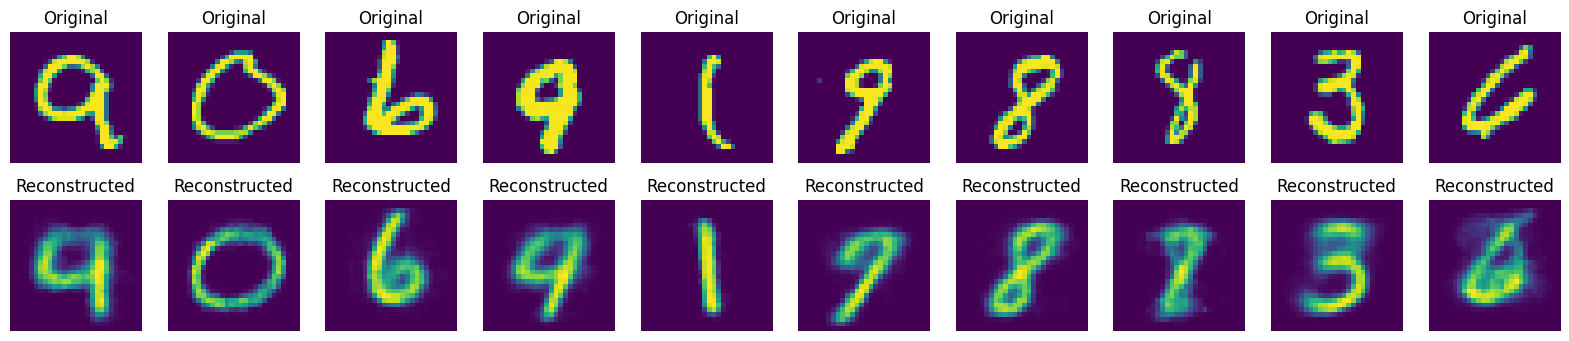

In [12]:
model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

# Plot original and reconstructed images side by side
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()